# Figure 1


In [8]:
from scriptsV2 import *


node = 'paper/100year/tmp/'
window = 365


#Get the data and take an average over the window
df = process_node(node)
df_mean = df.groupby([df.index//window, 'label','level','precision', 'title'],as_index=False).mean()



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [9]:
df

,temperature,label,level,precision,title,X
0,286.025455,speedyone100yr_L2_52_RN_m5,L2,52_RN,EC Earth SST. ablco2=6,0
1,286.725405,speedyone100yr_L2_52_RN_m5,L2,52_RN,EC Earth SST. ablco2=6,1
2,286.979427,speedyone100yr_L2_52_RN_m5,L2,52_RN,EC Earth SST. ablco2=6,2
3,287.126005,speedyone100yr_L2_52_RN_m5,L2,52_RN,EC Earth SST. ablco2=6,3
4,287.245411,speedyone100yr_L2_52_RN_m5,L2,52_RN,EC Earth SST. ablco2=6,4
...,...,...,...,...,...,...
27370,291.664975,speedyone100yr_L2_10_RN_m5,L2,10_RN,EC Earth SST. ablco2=6,27370
27371,291.594422,speedyone100yr_L2_10_RN_m5,L2,10_RN,EC Earth SST. ablco2=6,27371
27372,291.482170,speedyone100yr_L2_10_RN_m5,L2,10_RN,EC Earth SST. ablco2=6,27372
27373,291.384554,speedyone100yr_L2_10_RN_m5,L2,10_RN,EC Earth SST. ablco2=6,27373


In [10]:
def plot_config(ax1,ax2,save):
    

    #Config
    plt.subplots_adjust(wspace=0.1, hspace=0)

    ax1.set_ylabel("Gloabl Mean Surface Temperature (K)")#, fontsize = 20)
    ax2.set_ylabel("Absolute Error (K)")#, fontsize = 20)


    ax2.set_xlabel("Time (days)")#, fontsize = 20)
    ax2.axhline(0.0, c='0.5', linestyle='--')
    

   # ax1.set_xlim(0,400)
    ax1.set_ylim(288.5,292)

    #Other config
    ax1.legend().set_title(None)
    
    if save:
        plt.savefig('figs/Fig1_Williams.png', dpi=300, bbox_inches='tight')


    
    
def get_relative_error_df(df):
    
    
    #Get a ground truth that all others will be compared against
    df_truth = df.query('precision == "52_RN" ')[['X', 'temperature']]
    df_truth['merge_column'] = df_truth['X'].astype(int)
    
    #Get the others
    df_rest = df.query('precision != "52_RN" ').reset_index(drop=True) #rest index to avoid SettingWithCopyWarning
    df_rest['merge_column'] = df_rest['X'].astype('int') 
    
    #Note integer conversions are needed for join

    #Rejoin - maybe a more efficient way to do this?
    df_join = pd.merge(df_rest,df_truth,how='left',on='merge_column', suffixes=(None, 'truth'))
    
    
    #Get the absolute error
    df_join['error']  = df_join['temperature'] - df_join['temperaturetruth']
    
    
    return df_join
    
def plot_error_timeseries(df,save_it):
    
    #Setup plot env
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    

    
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(h,w))
    
    
    #Plot the df directly
    p = sns.lineplot(data=df, x="X", y='temperature', hue="precision",ax=ax1,style='precision',markers=True)


    #Calculate the relative_error df and plot
    df_error = get_relative_error_df(df)
    p = sns.lineplot(data=df_error, x="X", y='error', hue="precision",ax=ax2,style='precision',markers=True,legend=None)


    plot_config(ax1,ax2,save_it)

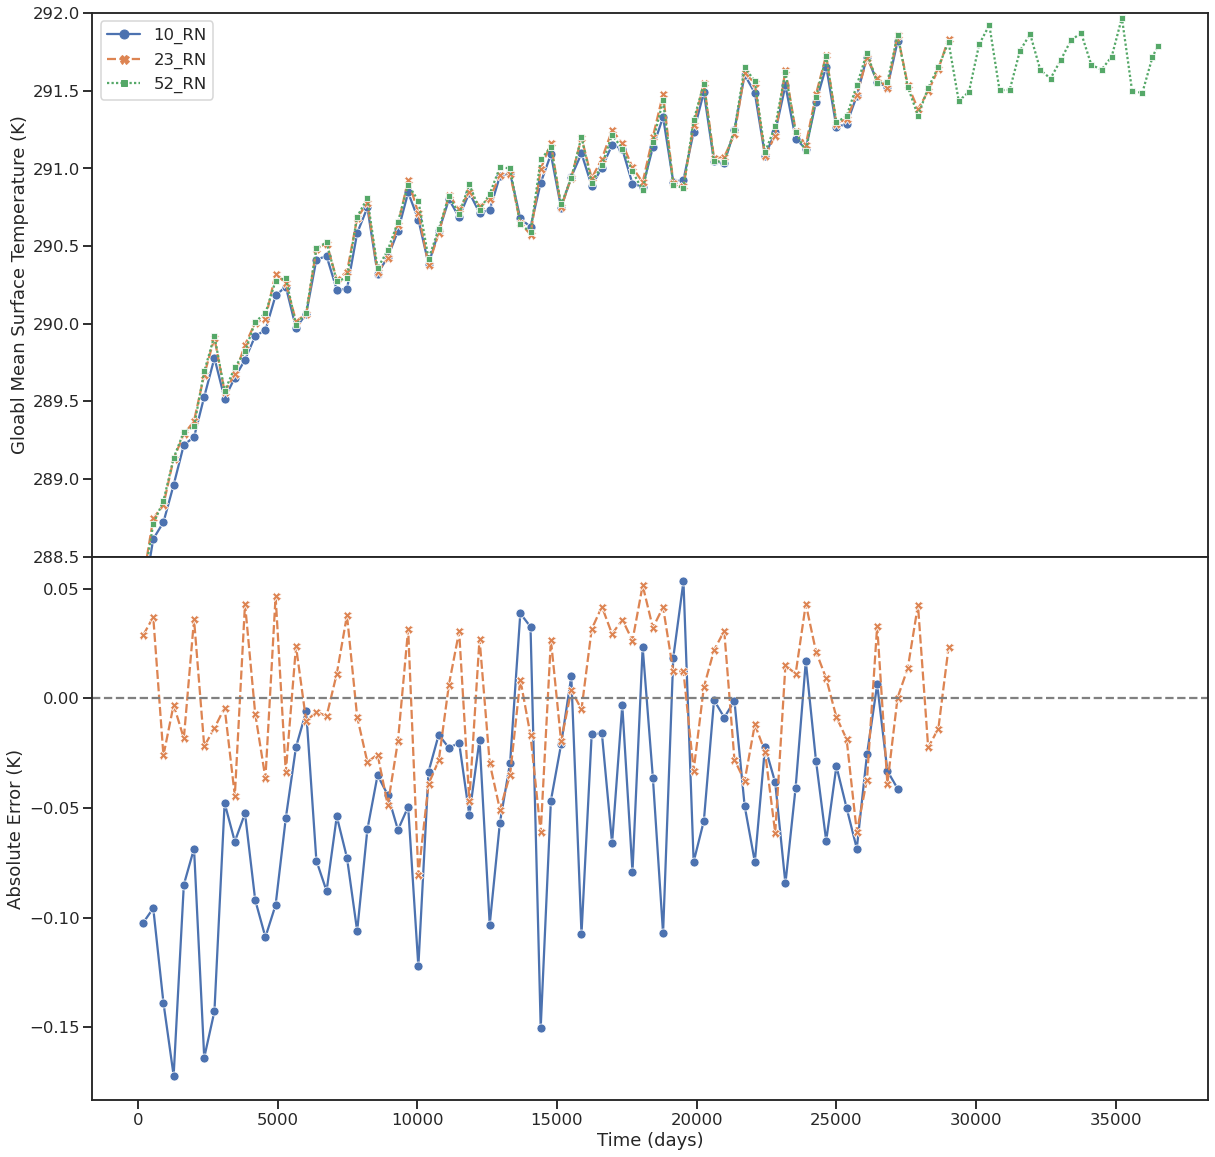

In [11]:
save_it = False #Do you want to save the Fig?
plot_error_timeseries(df_mean,save_it)

# Errors and bias

In [12]:
df52 = df_mean.query("precision == '52_RN'")
dfREST = df_mean.query("precision != '52_RN'")


In [13]:
#Pivot data to allow us to subtract to get difference
df_pivot = pd.merge(dfREST, df52, on = 'X', suffixes = (None, '_true'))
df_pivot['MBE'] =  df_pivot['temperature'] - df_pivot['temperature_true']
df_pivot['MBE_squared'] = df_pivot['MBE']**2

#We dont care about the 23 bit solution here
#df_pivot = df_pivot[df_pivot.precision != '23_RN']





In [14]:
df_pivot_averaged = df_pivot.groupby(['precision']).mean()
df_pivot_averaged['RMSE'] = np.sqrt(df_pivot_averaged['MBE_squared'])
display(df_pivot_averaged)



,temperature,X,temperature_true,MBE,MBE_squared,RMSE
precision,,,,,,
10_RN,289.559105,1824.5,289.634688,-0.075583,0.007557,0.086932
10_SR,289.665222,1824.5,289.634688,0.030534,0.001461,0.038219
23_RN,289.654244,1824.5,289.634688,0.019556,0.001416,0.037625
